<a href="https://colab.research.google.com/github/vhrique/ELF/blob/main/hypernetworks_for_local_logistic_regression_rand_interpolate_augmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch

import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.datasets import load_iris
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

In [2]:
dataset = load_iris()
X = dataset.data
y = dataset.target == 1

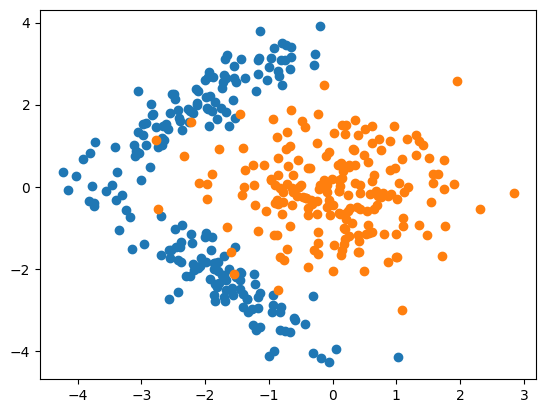

In [3]:
mean = [-2, -2]
covariance = [
    [1, -0.9],
    [-0.9, 1]
]
X1 = np.random.multivariate_normal(mean, covariance, 100)
y1 = np.ones((len(X1),)) == 1

mean = [-2, 2]
covariance = [
    [1, 0.9],
    [0.9, 1]
]
X2 = np.random.multivariate_normal(mean, covariance, 100)
y2 = np.ones((len(X2),)) == 1

mean = [0, 0]
covariance = [
    [1, 0],
    [0, 1]
]
X3 = np.random.multivariate_normal(mean, covariance, 200)
y3 = np.zeros((len(X3),)) == 1

X = np.concatenate([X1, X2, X3])
y = np.concatenate([y1, y2, y3])
plt.scatter(X[y,0], X[y,1])
plt.scatter(X[~y,0], X[~y,1])
plt.show()

In [4]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5)

In [5]:
scaler = StandardScaler().fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

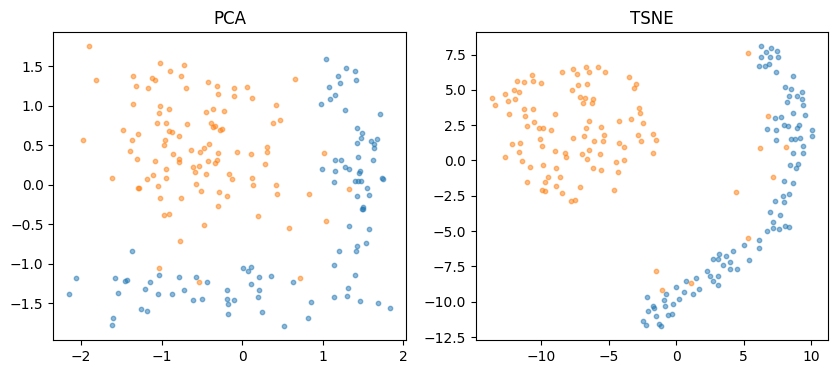

In [6]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

X_2d = PCA(n_components=2).fit_transform(X_train)
axs[0].scatter(X_2d[y_train==1,0], X_2d[y_train==1,1], alpha=0.5, s=10)
axs[0].scatter(X_2d[y_train==0,0], X_2d[y_train==0,1], alpha=0.5, s=10)
axs[0].set_title('PCA')

X_2d = TSNE(n_components=2).fit_transform(X_train)
axs[1].scatter(X_2d[y_train==1,0], X_2d[y_train==1,1], alpha=0.5, s=10)
axs[1].scatter(X_2d[y_train==0,0], X_2d[y_train==0,1], alpha=0.5, s=10)
axs[1].set_title('TSNE')

plt.show()

In [7]:
y_pred = LogisticRegression()\
         .fit(X_train, y_train)\
         .predict(X_test)

print(
    classification_report(
        y_test, y_pred
    )
)

              precision    recall  f1-score   support

       False       0.89      0.82      0.85        96
        True       0.85      0.90      0.87       104

    accuracy                           0.86       200
   macro avg       0.87      0.86      0.86       200
weighted avg       0.87      0.86      0.86       200



In [8]:
y_pred = MLPClassifier(hidden_layer_sizes=(32,32))\
         .fit(X_train, y_train)\
         .predict(X_test)

print(
    classification_report(
        y_test, y_pred
    )
)

              precision    recall  f1-score   support

       False       0.99      0.95      0.97        96
        True       0.95      0.99      0.97       104

    accuracy                           0.97       200
   macro avg       0.97      0.97      0.97       200
weighted avg       0.97      0.97      0.97       200



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:690: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [82]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y, augment=''):
        self.X = X
        self.y = y
        self.augment = augment
        self.knn = {}
        for y in np.unique(self.y):
            self.knn[y.item()] = NearestNeighbors(n_neighbors=1).fit(self.X[self.y != y])

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        hyper_sample = self.X[idx]
        if 'interpolate_oposite' in self.augment:
            n_idx = self.knn[self.y[idx].item()].kneighbors(self.X[[idx]], return_distance=False)[0][0]
            diff = self.X[self.y != self.y[idx]][n_idx] - self.X[idx]
            r = torch.rand(diff.shape)
            hyper_sample = hyper_sample + r*diff
        if 'rand' in self.augment:
            hyper_sample = hyper_sample + (torch.rand(hyper_sample.shape)-0.5)
        return hyper_sample, self.X[idx], self.y[idx]

In [96]:
# Dataset and DataLoader for batching
X_train_t = torch.tensor(X_train, dtype=torch.float32)
y_train_t = torch.tensor(y_train, dtype=torch.float32)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.float32)

batch_size = 32
# train_dataset = Dataset(X_train_t, y_train_t, augment='rand') # Augmentation - good results and interpretability
# train_dataset = Dataset(X_train_t, y_train_t, augment='interpolate_oposite') # Augmentation - good results and interpretability
train_dataset = Dataset(X_train_t, y_train_t, augment='interpolate_oposite+rand') # Augmentation - good results and interpretability
# train_dataset = Dataset(X_train_t, y_train_t) # No augmentation - good results, but no interpretability
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataset = Dataset(X_test_t, y_test_t)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

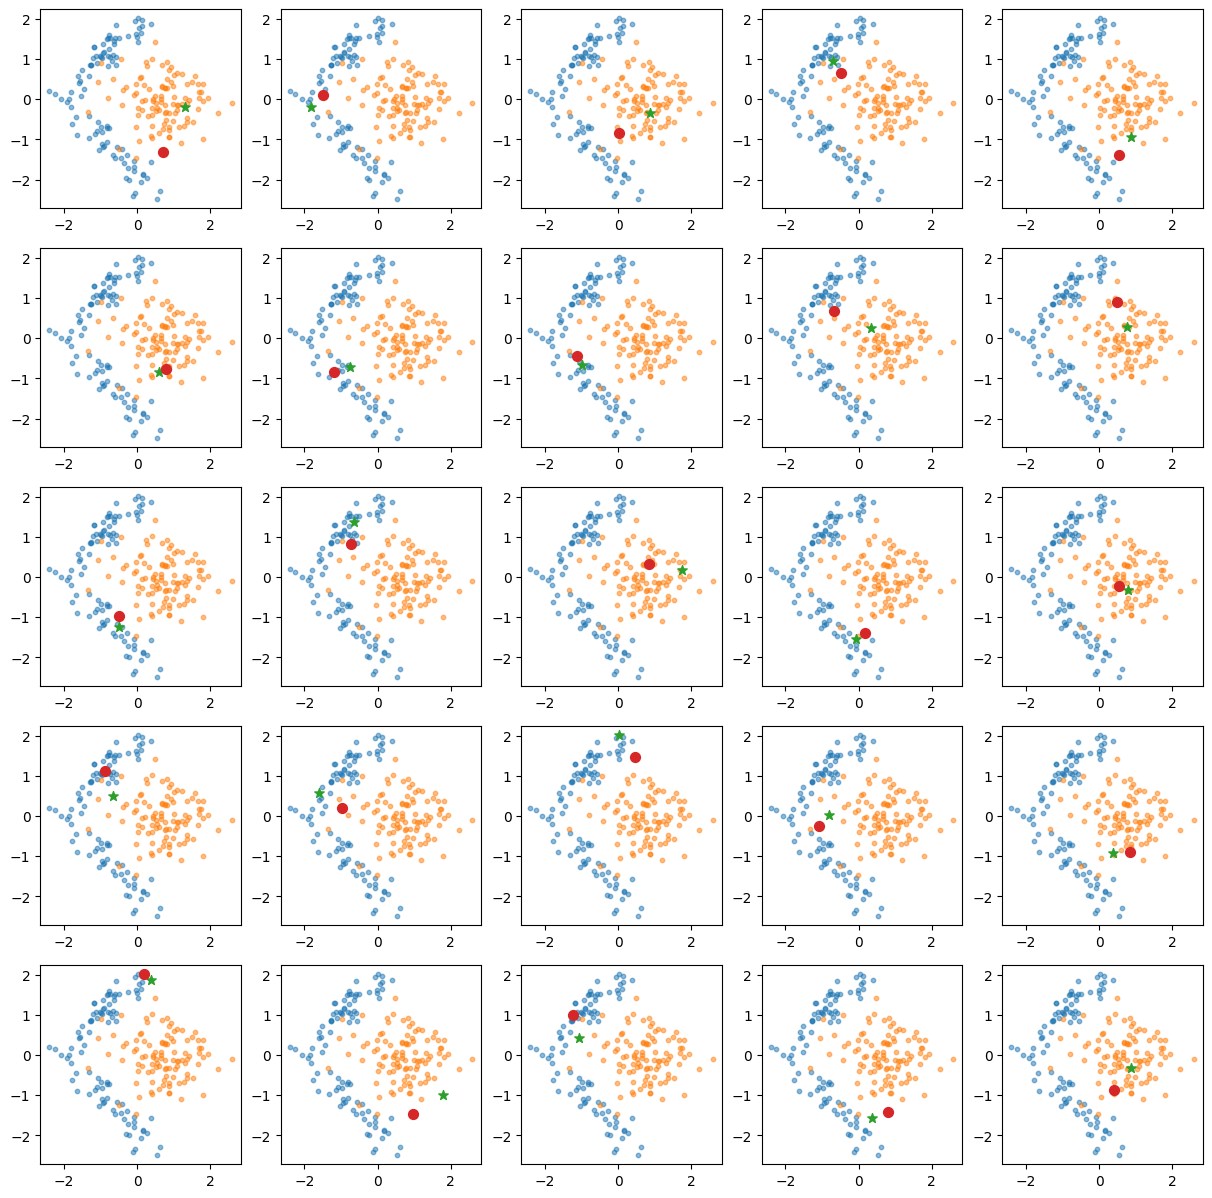

In [97]:
fig, axs = plt.subplots(5,5,figsize=(15,15))

for i in range(5):
    for j in range(5):
        idx = np.random.choice(np.arange(len(X_train)), 1)[0]
        X_hyper, X_sample, _ = train_dataset[idx]

        axs[i,j].scatter(X_train[y_train == 1,0], X_train[y_train == 1,1], alpha=0.5, s=10, marker='o')
        axs[i,j].scatter(X_train[y_train == 0,0], X_train[y_train == 0,1], alpha=0.5, s=10, marker='o')
        axs[i,j].scatter(X_sample[0], X_sample[1], s=50, marker='*')
        axs[i,j].scatter(X_hyper[0], X_hyper[1], s=50, marker='o')

plt.show()

In [98]:
class HyperNetwork(torch.nn.Module):
    def __init__(self, input_dim, hidden_dims, output_dim):
        super(HyperNetwork, self).__init__()
        layers = []
        prev_dim = input_dim
        for i, hidden_dim in enumerate(hidden_dims):
            layers.append(torch.nn.Linear(prev_dim, hidden_dim))
            layers.append(torch.nn.ReLU())
            prev_dim = hidden_dim
        layers.append(torch.nn.Linear(prev_dim, output_dim))
        self.network = torch.nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

class LogisticRegressionModel(torch.nn.Module):
    def __init__(self, hypernetwork):
        super(LogisticRegressionModel, self).__init__()
        self.hypernetwork = hypernetwork

    def forward(self, xh, xn):
        params = self.hypernetwork(xh)
        logits = torch.bmm(xn.unsqueeze(1), params[:,:-1].unsqueeze(-1))
        logits = logits + params[:,-1].unsqueeze(-1).unsqueeze(-1)
        return logits.squeeze(-1), params

In [99]:
# Initialize models
input_dim = X_train.shape[1]  # Number of input features
hidden_dims = (32,)  # Hidden dimensions of MLP
output_dim = input_dim + 1  # Output dimension for logistic regression weights

hypernetwork = HyperNetwork(input_dim, hidden_dims, output_dim)
logistic_model = LogisticRegressionModel(hypernetwork)

In [100]:
# Loss and optimizer
learning_rate = 0.01
alpha = 0.000
beta = 0.000
criterion = torch.nn.BCEWithLogitsLoss()  # Binary Cross Entropy loss
optimizer = torch.optim.Adam(logistic_model.parameters(), lr=learning_rate)

In [101]:
# Training loop
epochs = 1000
logistic_model.train()
for epoch in tqdm(range(epochs)):
    for i, data in enumerate(train_dataloader):
        batch_features1, batch_features2, batch_targets = data

        # Forward pass
        logits, weights = logistic_model(batch_features1, batch_features2)

        # BCEwithLogitsLoss + L1 Regularization + L2 Regularization
        loss = criterion(logits.squeeze(), batch_targets)
        loss += alpha * weights.abs().sum()
        loss += beta * weights.pow(2).sum()

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

100%|██████████| 1000/1000 [03:46<00:00,  4.41it/s]


In [102]:
# Testing loop
logistic_model.eval()
y_pred = []
sample_weights = []
for i, data in enumerate(test_dataloader):
    batch_features1, batch_features2, batch_targets = data

    # Forward pass
    logits, weights = logistic_model(batch_features1, batch_features2)
    y_pred.append(torch.sigmoid(logits).detach().numpy())
    sample_weights.append(weights.detach().numpy())

y_pred = np.concatenate(y_pred, axis=0)
sample_weights = np.concatenate(sample_weights, axis=0)
sample_weights_n = StandardScaler().fit_transform(sample_weights)

print(
    classification_report(
        y_test, y_pred > 0.5
    )
)

              precision    recall  f1-score   support

       False       1.00      0.97      0.98        96
        True       0.97      1.00      0.99       104

    accuracy                           0.98       200
   macro avg       0.99      0.98      0.98       200
weighted avg       0.99      0.98      0.98       200



In [103]:
tp = (y_test == 1) & (y_pred[:,0] > 0.5)
fp = (y_test == 0) & (y_pred[:,0] > 0.5)
fn = (y_test == 1) & (y_pred[:,0] <= 0.5)
tn = (y_test == 0) & (y_pred[:,0] <= 0.5)

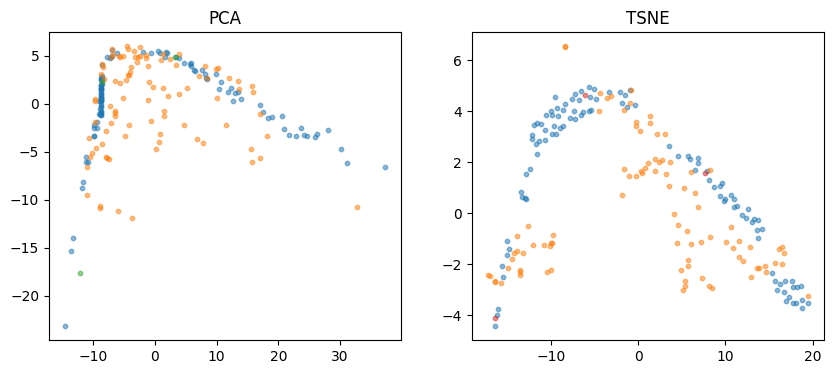

In [104]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

X_2d = PCA(n_components=2).fit_transform(sample_weights)
axs[0].scatter(X_2d[tp,0], X_2d[tp,1], alpha=0.5, s=10)
axs[0].scatter(X_2d[tn,0], X_2d[tn,1], alpha=0.5, s=10)
axs[0].scatter(X_2d[fp,0], X_2d[fp,1], alpha=0.5, s=10)
axs[0].scatter(X_2d[fn,0], X_2d[fn,1], alpha=0.5, s=10)
axs[0].set_title('PCA')

X_2d = TSNE(n_components=2).fit_transform(sample_weights)
axs[1].scatter(X_2d[tp,0], X_2d[tp,1], alpha=0.5, s=10)
axs[1].scatter(X_2d[tn,0], X_2d[tn,1], alpha=0.5, s=10)
axs[1].scatter(X_2d[fn,0], X_2d[fn,1], alpha=0.5, s=10)
axs[1].scatter(X_2d[fp,0], X_2d[fp,1], alpha=0.5, s=10)
axs[1].set_title('TSNE')

plt.show()

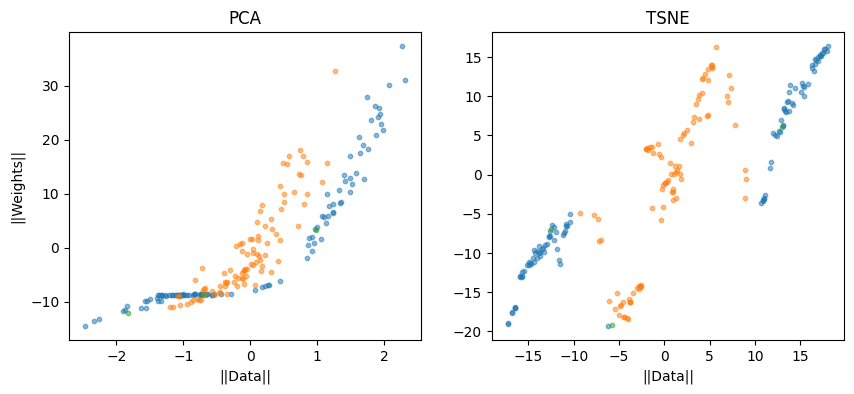

In [105]:
fig, axs = plt.subplots(1, 2, figsize=(10,4))

w_1d = PCA(n_components=1).fit_transform(sample_weights)
X_1d = PCA(n_components=1).fit_transform(X_test)
axs[0].scatter(X_1d[tp,0], w_1d[tp,0], alpha=0.5, s=10)
axs[0].scatter(X_1d[tn,0], w_1d[tn,0], alpha=0.5, s=10)
axs[0].scatter(X_1d[fp,0], w_1d[fp,0], alpha=0.5, s=10)
axs[0].scatter(X_1d[fn,0], w_1d[fn,0], alpha=0.5, s=10)
axs[0].set_title('PCA')
axs[0].set_xlabel('||Data||')
axs[0].set_ylabel('||Weights||')

w_1d = TSNE(n_components=1).fit_transform(sample_weights)
X_1d = TSNE(n_components=1).fit_transform(X_test)
axs[1].scatter(X_1d[tp,0], w_1d[tp,0], alpha=0.5, s=10)
axs[1].scatter(X_1d[tn,0], w_1d[tn,0], alpha=0.5, s=10)
axs[1].scatter(X_1d[fp,0], w_1d[fp,0], alpha=0.5, s=10)
axs[1].scatter(X_1d[fn,0], w_1d[fn,0], alpha=0.5, s=10)
axs[1].set_title('TSNE')
axs[1].set_xlabel('||Data||')

plt.show()

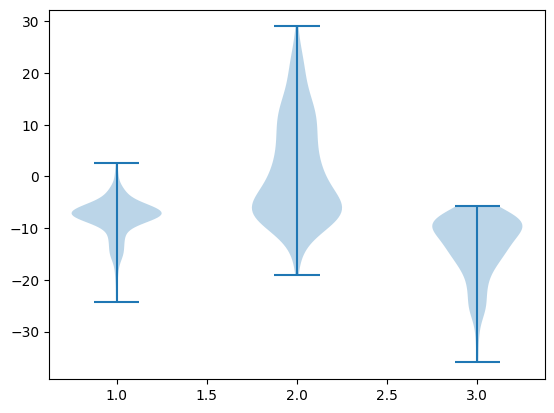

In [106]:
plt.violinplot(sample_weights)
plt.show()

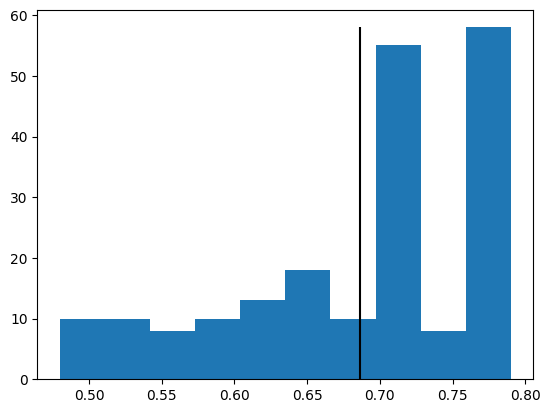

In [107]:
accuracies = []
for weights in sample_weights:
    y_pred = (X_test * weights[:-1]).sum(axis=1) + weights[-1]
    acc = np.mean((y_test > 0.5) == (y_pred > 0))
    accuracies.append(acc)

hist_data = plt.hist(accuracies)
plt.vlines(np.mean(accuracies), 0, np.max(hist_data[0]), color='black')
plt.show()

In [108]:
def plot_decision_boundary(model, X, y, idx, axis=None):
    xx, yy = np.meshgrid(np.arange(X[:,0].min(), X[:,0].max(), 0.01),
                         np.arange(X[:,1].min(), X[:,1].max(), 0.01))

    X_grid = torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)
    X_h = torch.tensor(X[idx], dtype=torch.float32)
    X_h = X_h.repeat(X_grid.shape[0], 1)

    Z = torch.nn.functional.sigmoid(model(X_h, X_grid)[0]).detach().numpy()
    Z = Z.reshape(xx.shape)

    if axis is None:
        plt.contourf(xx, yy, Z, alpha=0.5, cmap='cividis', antialiased=True)
        plt.scatter(X[~y,0], X[~y,1], s=10)
        plt.scatter(X[y,0], X[y,1], s=10)
        plt.xlim(X[:,0].min(), X[:,0].max())
        plt.ylim(X[:,1].min(), X[:,1].max())
        plt.xlabel('x0')
        plt.ylabel('x1')
    else:
        axis.contourf(xx, yy, Z, alpha=0.5, cmap='cividis', antialiased=True)
        axis.scatter(X[~y,0], X[~y,1], s=10)
        axis.scatter(X[y,0], X[y,1], s=10)
        axis.set_xlim(X[:,0].min(), X[:,0].max())
        axis.set_ylim(X[:,1].min(), X[:,1].max())
        axis.set_xlabel('x0')
        axis.set_ylabel('x1')

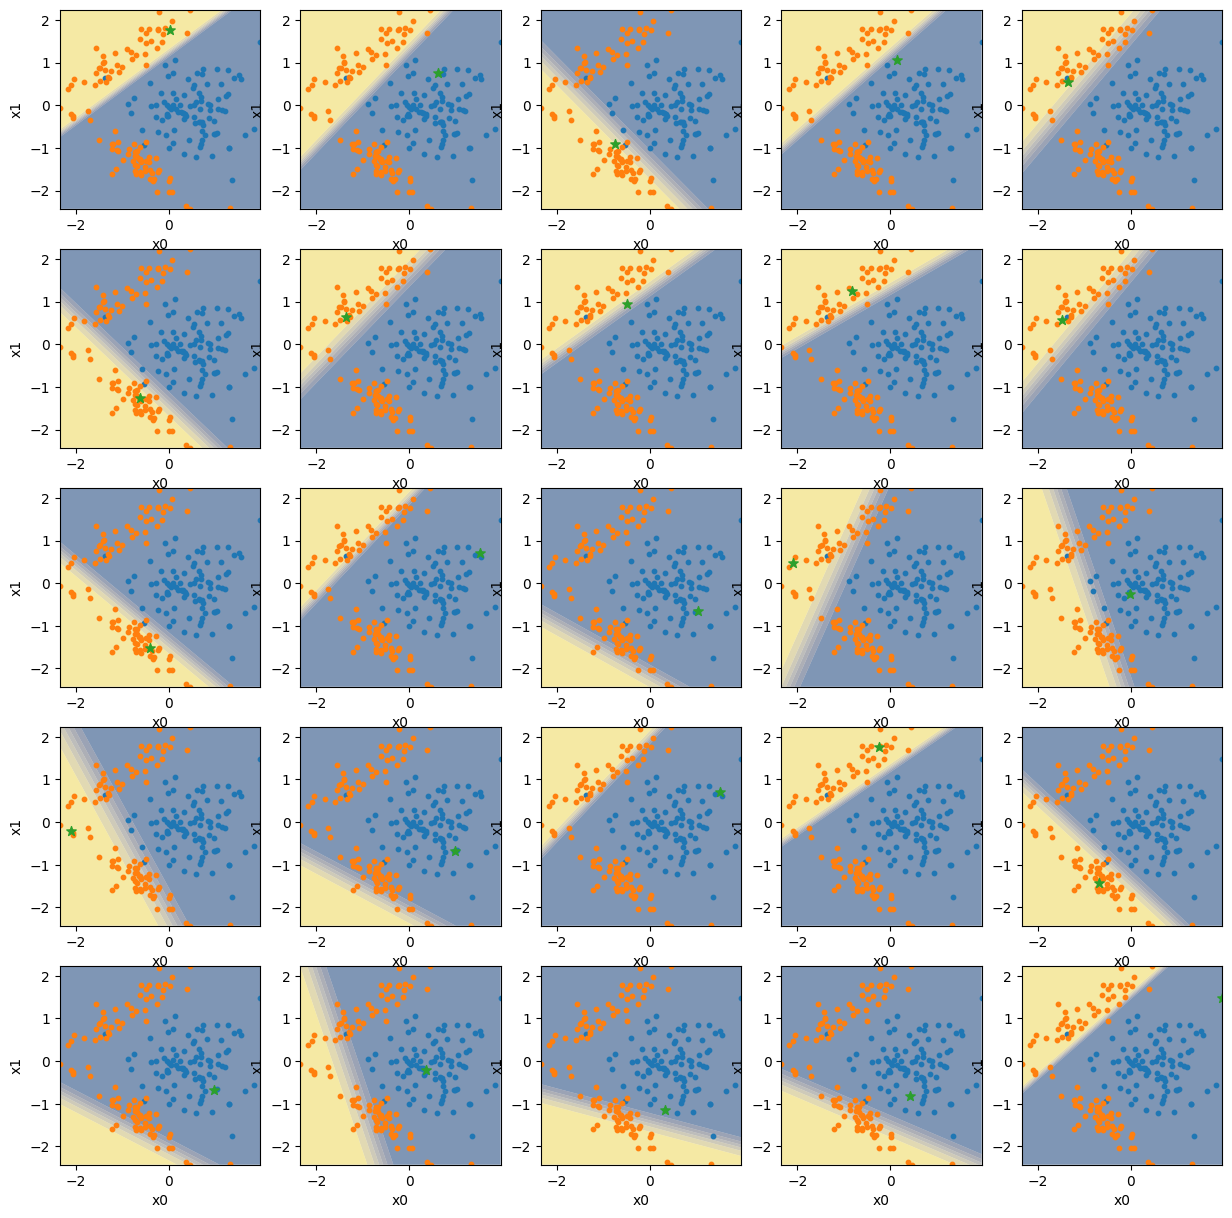

In [109]:
fig, axs = plt.subplots(5,5,figsize=(15,15))

for i in range(5):
    for j in range(5):
        idx = np.random.choice(np.arange(len(X_test)), 1)

        plot_decision_boundary(logistic_model, X_test, y_test, idx, axs[i,j])

        # y_pred = ((X_test * sample_weights[idx,:-1]).sum(axis=1) + sample_weights[idx,-1]) > 0

        # tpw = (y_test == 1) & (y_pred > 0.0)
        # fpw = (y_test == 0) & (y_pred > 0.0)
        # fnw = (y_test == 1) & (y_pred <= 0.0)
        # tnw = (y_test == 0) & (y_pred <= 0.0)

        # axs[i,j].scatter(X_test[tpw,0], X_test[tpw,1], alpha=0.5, s=10, marker='o')
        # axs[i,j].scatter(X_test[tnw,0], X_test[tnw,1], alpha=0.5, s=10, marker='o')
        # axs[i,j].scatter(X_test[fpw,0], X_test[fpw,1], alpha=0.5, s=10, marker='x')
        # axs[i,j].scatter(X_test[fnw,0], X_test[fnw,1], alpha=0.5, s=10, marker='x')

        axs[i,j].scatter(X_test[idx,0], X_test[idx,1], s=50, marker='*')

plt.show()